In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import arviz as az

In [2]:
az.style.use('arviz-darkgrid')

## Non-Markovian methods

### Grid computing


In [3]:
def posterior_grid(grid_points=50, heads=6, tails=9):
    """ 
    A grid implementation for the coin-flipping problem 
    """
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(1/grid_points, grid_points)  # uniform prior
    likelihood = stats.binom.pmf(heads, heads+tails, grid)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    return grid, posterior

Assuming we flip a coin 13 times and we observed 3 head we have:

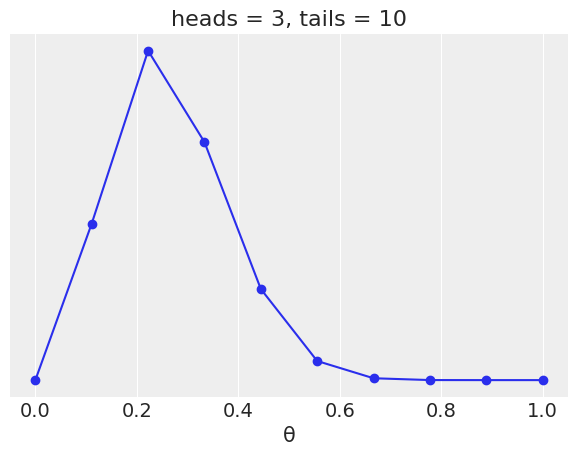

In [4]:
data = np.repeat([0, 1], (10, 3))
points = 10
h = data.sum()
t = len(data) - h
grid, posterior = posterior_grid(points, h, t) 

plt.plot(grid, posterior, 'o-')

plt.title(f'heads = {h}, tails = {t}')
plt.yticks([])
plt.xlabel('θ');
plt.savefig('B11197_08_01.png')

### Quadratic method

In [5]:
with pm.Model() as normal_aproximation:
    p = pm.Beta('p', 1., 1.)
    w = pm.Binomial('w',n=1, p=p, observed=data)
    mean_q = pm.find_MAP()
    std_q = ((1/pm.find_hessian(mean_q, vars=[p]))**0.5)[0]
mean_q['p'], std_q

/home/osvaldo/proyectos/00_PyMC3/pymc3/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -9.0109, ||grad|| = 3.5: 100%|██████████| 7/7 [00:00<00:00, 1819.77it/s]


(array(0.23076923), array([0.11685454]))

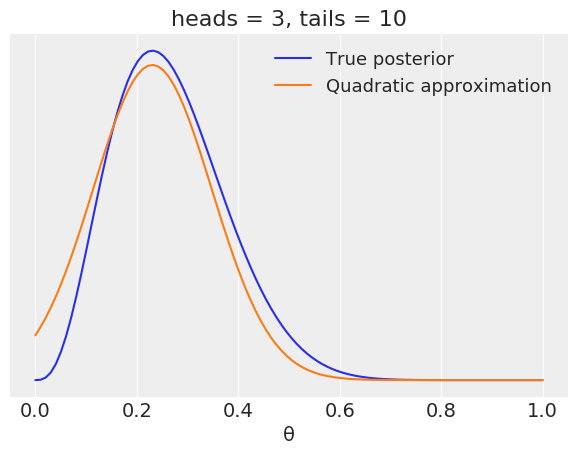

In [6]:
# analytical calculation
x = np.linspace(0, 1, 100)
plt.plot(x, stats.beta.pdf(x , h+1, t+1),
         label='True posterior')

# quadratic approximation
plt.plot(x, stats.norm.pdf(x, mean_q['p'], std_q),label='Quadratic approximation')
plt.legend(loc=0, fontsize=13)

plt.title(f'heads = {h}, tails = {t}')
plt.xlabel('θ', fontsize=14)
plt.yticks([])
plt.savefig('B11197_08_03.png');

## Markovian methods

### Monte Carlo


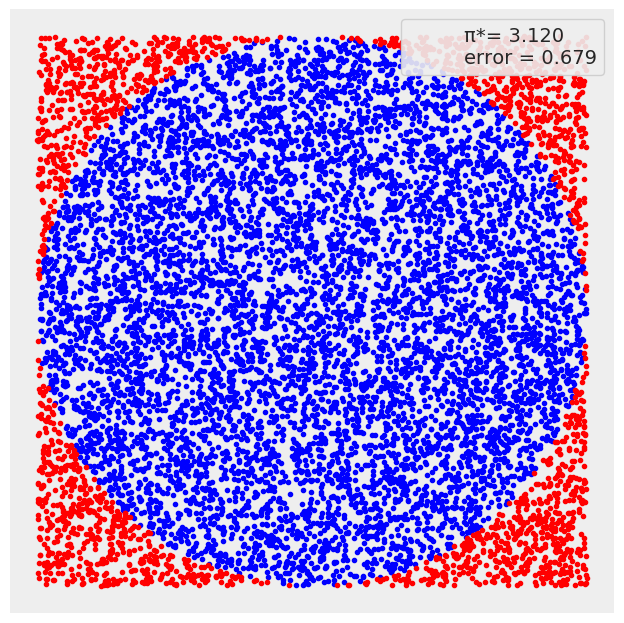

In [7]:
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi) / pi) * 100
 
outside = np.invert(inside)
 
plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')
plt.plot(0, 0, label=f'π*= {pi:4.3f}\nerror = {error:4.3f}', alpha=0)
plt.axis('square')
plt.xticks([])
plt.yticks([])
plt.legend(loc=1, frameon=True, framealpha=0.9)
plt.savefig('B11197_08_04.png');

In [8]:
def metropolis(func, draws=10000):
    """A very simple Metropolis implementation"""
    trace = np.zeros(draws)
    old_x = 0.5  # func.mean()
    old_prob = func.pdf(old_x)

    delta = np.random.normal(0, 0.5, draws)
    for i in range(draws):
        new_x = old_x + delta[i]
        new_prob = func.pdf(new_x)
        acceptance = new_prob / old_prob
        if acceptance >= np.random.random():
            trace[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            trace[i] = old_x

    return trace

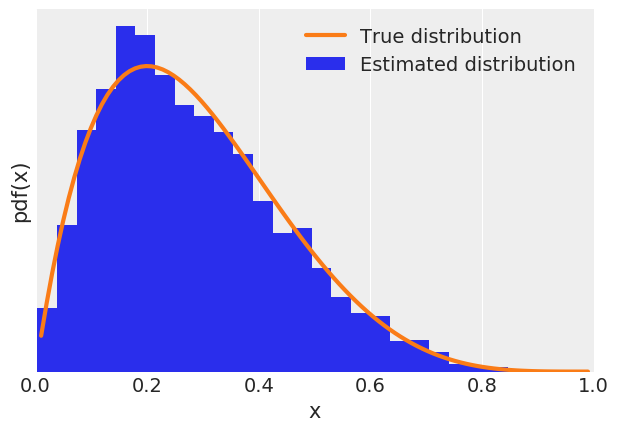

In [9]:
np.random.seed(3)
func = stats.beta(2, 5) 
trace = metropolis(func=func) 
x = np.linspace(0.01, .99, 100) 
y = func.pdf(x) 
plt.xlim(0, 1) 
plt.plot(x, y, 'C1-', lw=3, label='True distribution') 
plt.hist(trace[trace > 0], bins=25, density=True, label='Estimated distribution') 
plt.xlabel('x') 
plt.ylabel('pdf(x)')
plt.yticks([]) 
plt.legend()
plt.savefig('B11197_08_05.png');

## Diagnosing the samples

In [10]:
with pm.Model() as centered_model:
    a = pm.HalfNormal('a', 10)
    b = pm.Normal('b', 0, a, shape=10)
    trace_cm = pm.sample(2000, random_seed=7)

with pm.Model() as non_centered_model:
    a = pm.HalfNormal('a', 10)

    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=10)
    b = pm.Deterministic('b', 0 + b_offset * a)
    trace_ncm = pm.sample(2000, random_seed=7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1010.67draws/s]
There were 88 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5465674186441168, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [b_offset, a]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:02<00:00, 2066.72draws/s]


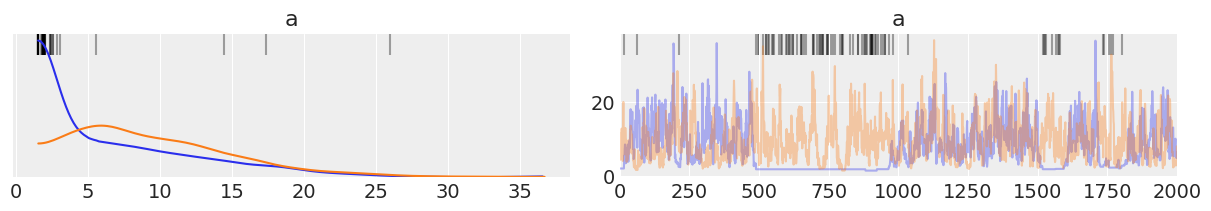

In [11]:
az.plot_trace(trace_cm, var_names=['a'], divergences='top')
plt.savefig('B11197_08_07.png');

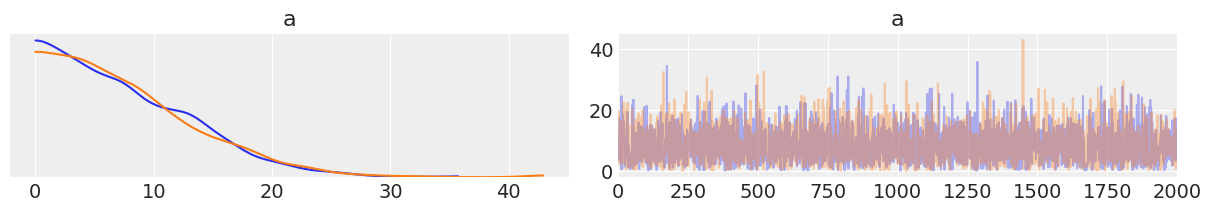

In [12]:
az.plot_trace(trace_ncm, var_names=['a'])
plt.savefig('B11197_08_08.png');

In [13]:
az.gelman_rubin(trace_cm)['a'].values

array(1.04)

The Gelman-rubin diagnostic is also computed by default under the name R_hat in `az.foresplot`, as you can see in the following image:

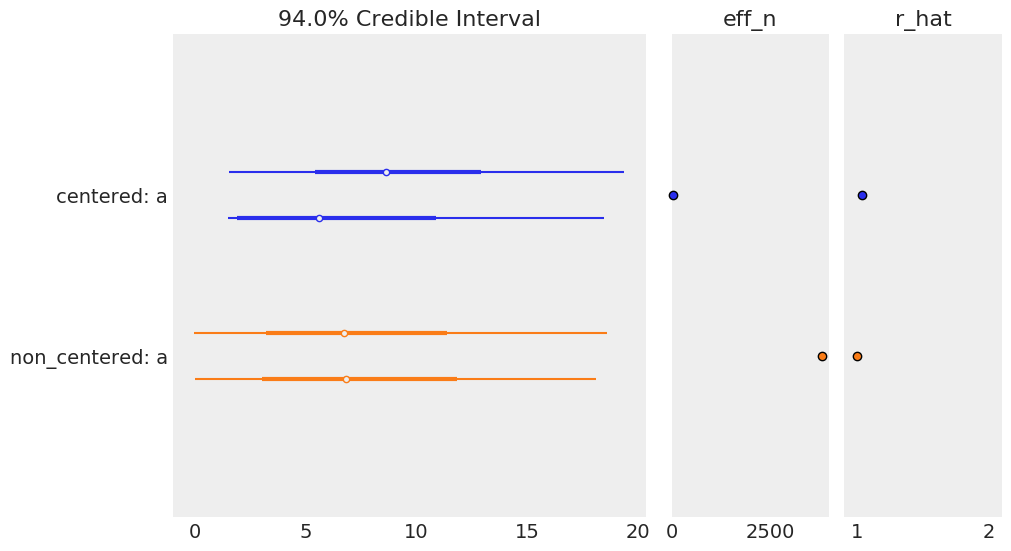

In [14]:
az.plot_forest([trace_cm, trace_ncm], model_names=['centered', 'non_centered'],
               var_names=['a'], r_hat=True, eff_n=True)
plt.savefig('B11197_08_10.png')

And also for `az.summary` 

In [15]:
summaries = pd.concat([az.summary(trace_cm, var_names=['a']),
           az.summary(trace_ncm, var_names=['a'])])
summaries.index = ['centered', 'non_centered']
summaries

,mean,sd,mc error,hpd 3%,hpd 97%,eff_n,r_hat
centered,8.53,5.84,0.58,1.53,18.87,49.0,1.04
non_centered,7.92,6.01,0.04,0.01,18.48,3817.0,1.00


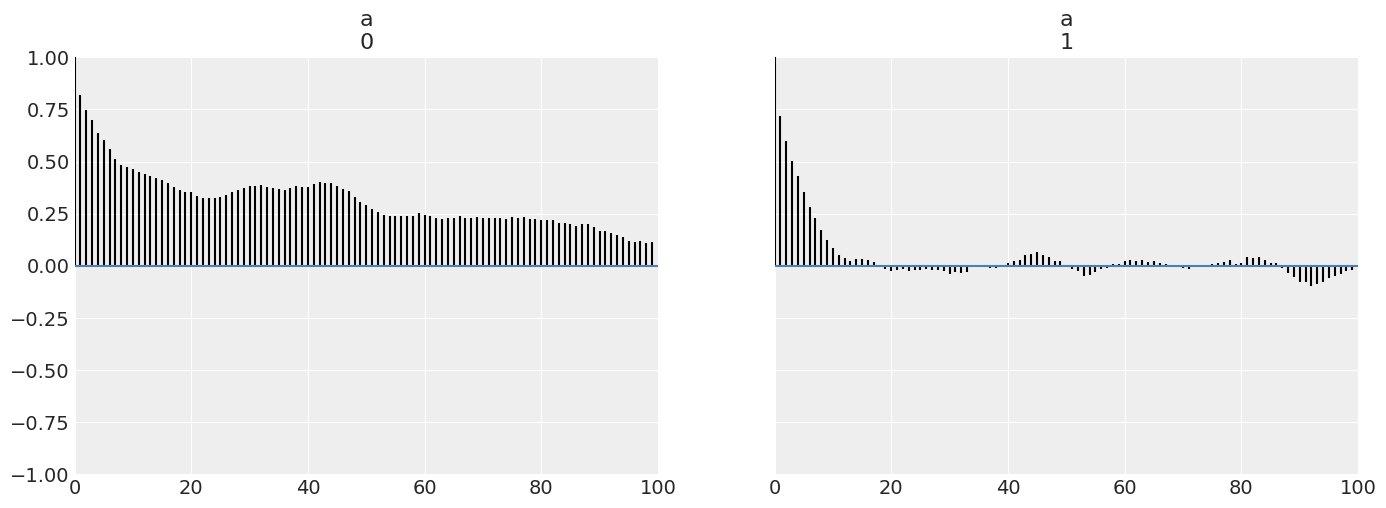

In [16]:
az.plot_autocorr(trace_cm, var_names=['a'])
plt.savefig('B11197_08_11.png');

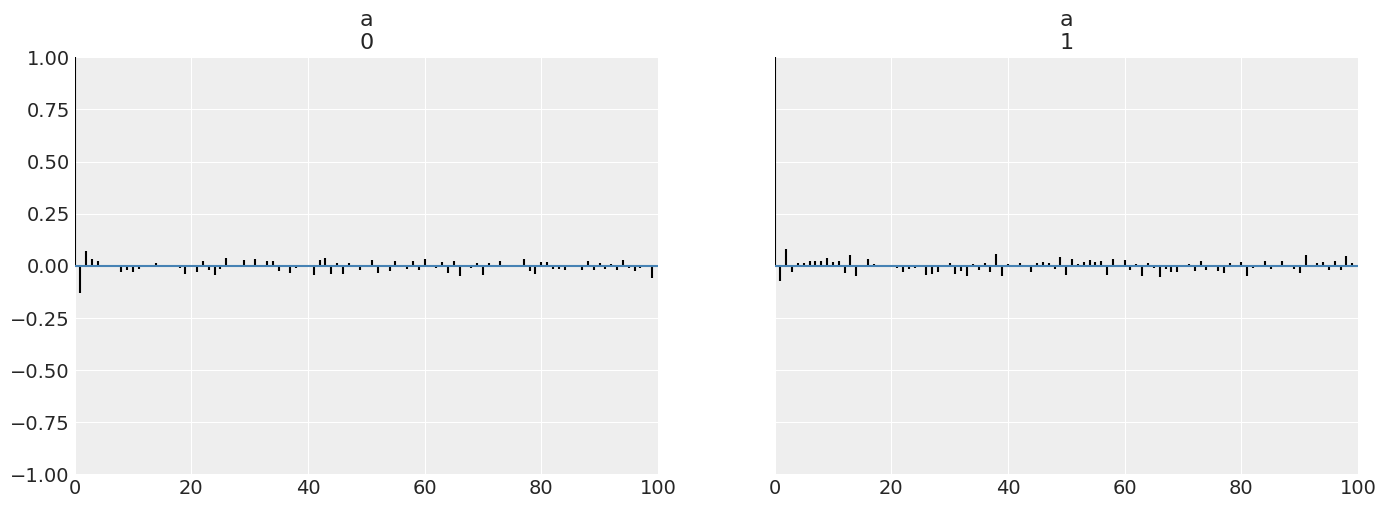

In [17]:
az.plot_autocorr(trace_ncm, var_names=['a'])
plt.savefig('B11197_08_12.png');

## Effective sample size

In [18]:
az.effective_n(trace_cm)['a'].values

array(49.)

## Divergences

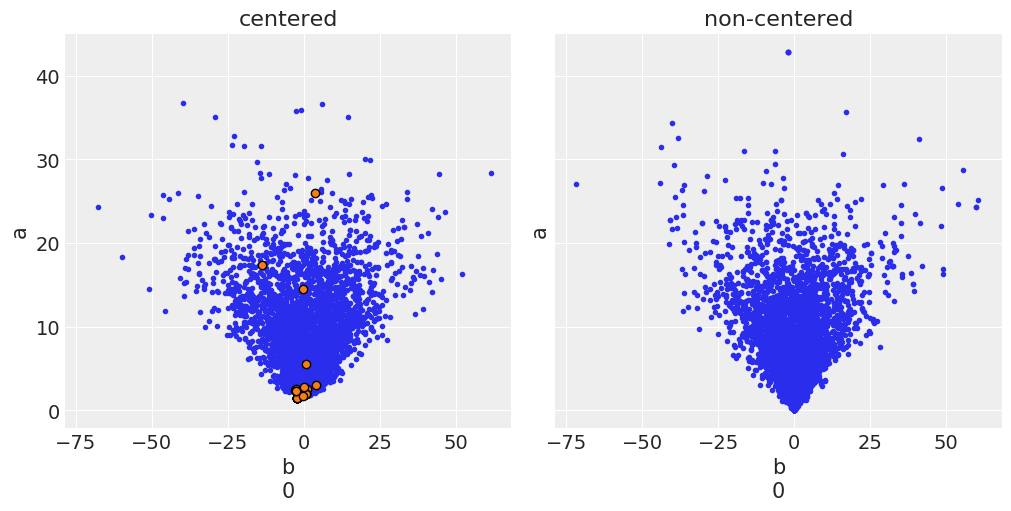

In [19]:
_, ax = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(10, 5), constrained_layout=True)

for idx, tr in enumerate([trace_cm, trace_ncm]):
    az.plot_pair(tr, var_names=['b', 'a'], coords={'b_dim_0':[0]}, kind='scatter',
                 divergences=True, contour=False, divergences_kwargs={'color':'C1'},
                 ax=ax[idx])
    ax[idx].set_title(['centered', 'non-centered'][idx])
plt.savefig('B11197_08_13.png');

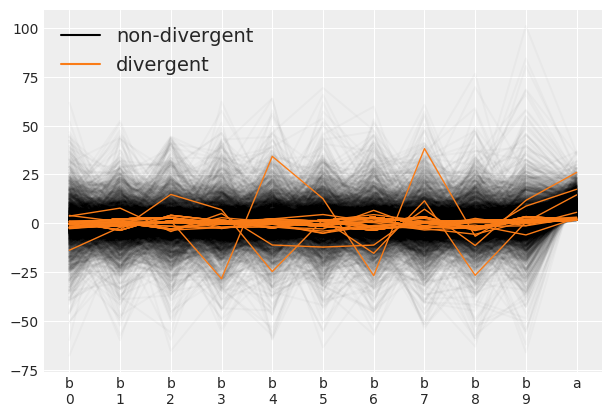

In [20]:
az.plot_parallel(trace_cm)
plt.savefig('B11197_08_14.png');